In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils

Using TensorFlow backend.


In [2]:
class CustomDataset(utils.Dataset):
    
    # Define a dictionary to map class names to class IDs
    class_names_to_ids = {"BG":0 ,"Topi": 1, "Baju": 2, "Jaket": 3, "Meja": 4}
    
    def add_custom_classes(self, class_names_to_ids):
        """Add custom classes to the dataset.
        
        Args:
        class_names_to_ids (dict): A dictionary mapping class names to class IDs.
        """
        for class_name, class_id in class_names_to_ids.items():
            self.add_class("custom", class_id, class_name)

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the custom dataset.
        
        Args:
        dataset_dir (str): Root directory of the dataset.
        subset (str): Subset to load: train or val.
        """
        # Add custom classes
        self.add_custom_classes(self.class_names_to_ids)
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        annotations = json.load(open(os.path.join(dataset_dir, "C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset_meja/train/labels/labels_train_VGG.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            custom = [s['region_attributes'] for s in a['regions'].values()]
            num_ids = []
            for n in custom:
                try:
                    # Map class names to class IDs
                    num_ids.append(self.class_names_to_ids[n['label']])
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "custom",
                image_id=a['filename'],  
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        
        Args:
        image_id (int): The unique identifier of the image.
        
        Returns:
        masks (ndarray): A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids (ndarray): A 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']    

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)    
        return mask, num_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [4]:
dataset_train = CustomDataset()
dataset_train.load_custom("C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/dataset_meja", "train") 
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))



# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

Train: 32


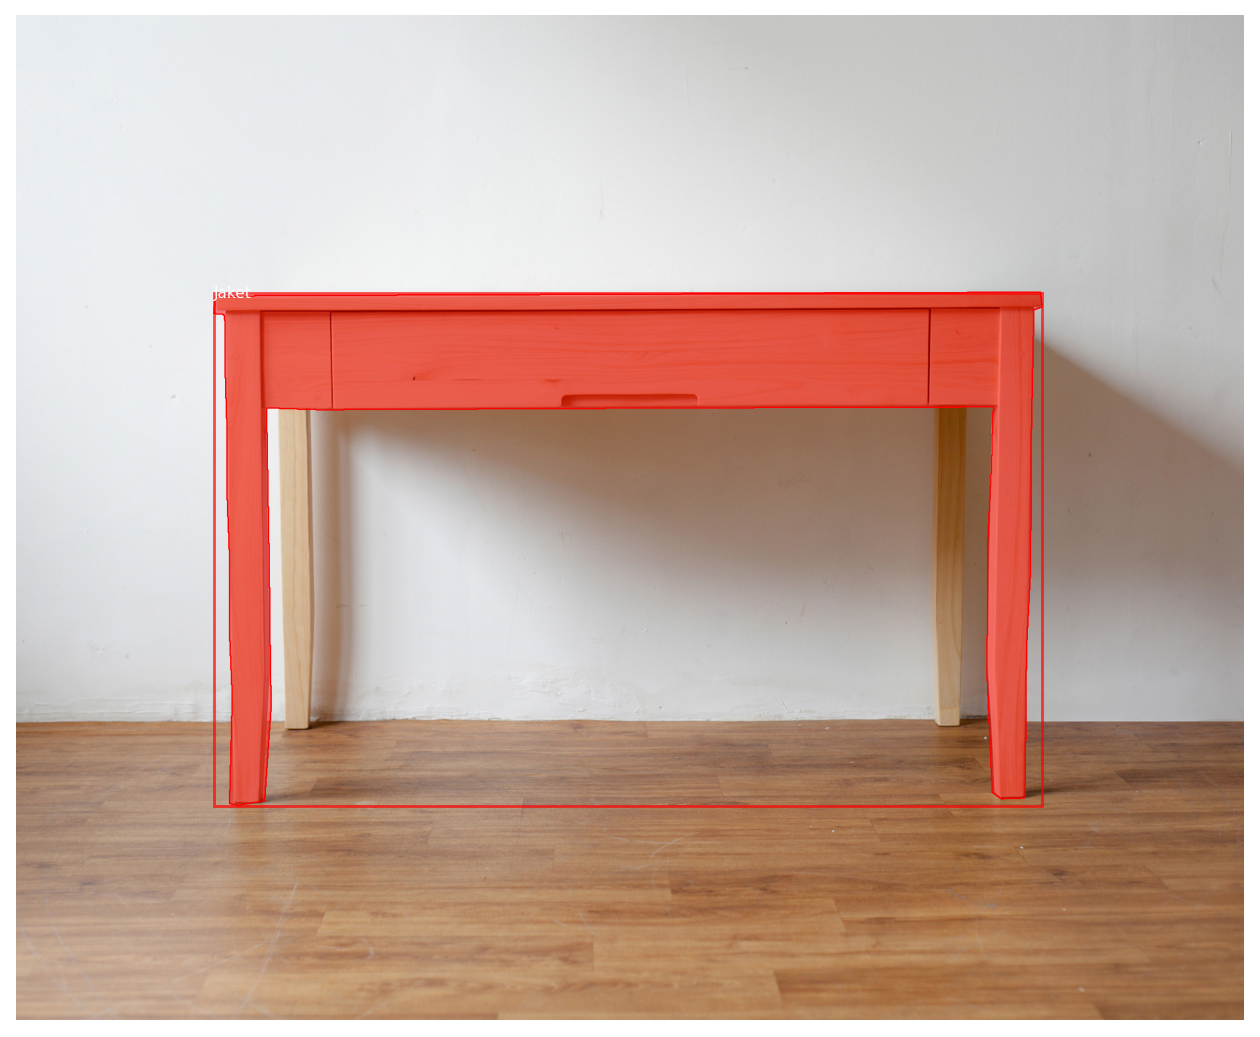


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# define a configuration for the model
class PakaianConfig(Config):
	# define the name of the configuration
	NAME = "pakaian_cfg"
	# number of classes (background + blue marble + non-Blue marble)
	NUM_CLASSES = 1 + 2
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = PakaianConfig()
config.display() 

In [6]:
ROOT_DIR = os.path.abspath("./")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "C:/Users/judit/Downloads/coba/Mask-RCNN-TF2/coco_weights/mask_rcnn_coco.h5")

In [7]:
########################
#Weights are saved to root D: directory. need to investigate how they can be
#saved to the directory defined... "logs_models"

###############

# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=25, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /logdir/train\mask_rcnn_pakaian_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistribute

C:\Users\judit\anaconda3\envs\maskrcnn_2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25


ValueError: Error when checking input: expected input_image_meta to have shape (15,) but got array with shape (18,)